## Example with CNN-LSTM on live BTC close price using the full data

In [23]:
import subprocess
import sys
import warnings
import os
from IPython.display import display, HTML

os.environ["TZ"] = "UTC"
warnings.filterwarnings("ignore")

USE_COLAB = False
if USE_COLAB == True:
    from google.colab import drive
    drive.mount('/content/drive')
    work_dir = '/content/drive/MyDrive/Colab Notebooks/sats4u/'
    secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'    
else:
    work_dir = '/Users/gabrieletocci/Google Drive/My Drive/Colab Notebooks/sats4u/'
    secret_data_folder = '/Users/gabrieletocci/Google Drive/My Drive/Colab Notebooks/crypto_project/crypto_data/'
    
# if 'darwin' in sys.platform:
#     print('Running \'caffeinate\' on MacOSX to prevent the system from sleeping')
#     subprocess.Popen('caffeinate')

os.chdir(work_dir)
dir_to_save = '/Users/gabrieletocci/Documents/projects/CODE/data_sats4u/'


In [24]:
! pip install -r requirements.txt

In [25]:
import json
import pandas as pd
import numpy as np
from binance.enums import *
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.timeutils as tu
import src.sats2backtest as s2b
import re

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)


## Load Asset Details, Binance client data and Download 15m candles from Binance

In [26]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details, data_folder,verbose=False)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i',testnet=False)
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)

In [27]:
secrets_filename_test = secret_data_folder+'data_test.json'
crypto_test = lc.CryptoData(asset_details,data_folder,verbose = False)
crypto_test.load_binance_client(secrets_filename_test,data1_str = 'DATA1',data2_str = 'DATA2i',testnet=True)
crypto_test.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto_test.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df_test = crypto_test.load_cryptos(tickers,save = False)  

### Generate Candles and build features from technical analysis

In [28]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 5000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts(verbose=True)
ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)

Candles Normalized
Extracted last 5000 steps
Generated time-series
Normalized 'candles_norm' with shape : (5000, 9)
Feature data 'x_candles' with size : 4952
Feature data with time intervals 'x_time' with size : 4952


In [29]:
USE_PRETRAINED = True
PRESAVED_MODELDATE = "220709_08_45"

initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler ,split_fraction = 1)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = False)
loaded_model.load_scaler(model_name + '/scaler.sav')
preds = c2t.denorm(loaded_model.scaler,can_btc.candles,loaded_model.preds)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [30]:
new_time_steps = int((can_btc.candles.index[-1] - initial_timestamp)/(can_btc.candles.index[1] - can_btc.candles.index[0]))
new_time_steps

1161

,Close,Pred Close
Date,,
2022-05-30 21:30:00,31603.72,31253.284262
2022-05-30 21:45:00,31807.98,31493.159925
2022-05-30 22:00:00,31640.78,31548.012777
2022-05-30 22:15:00,31664.72,31758.314773
2022-05-30 22:30:00,31698.50,31602.027681
...,...,...
2022-07-21 10:00:00,23050.27,22901.209320
2022-07-21 10:15:00,22972.31,22930.943376
2022-07-21 10:30:00,22945.87,22977.331645


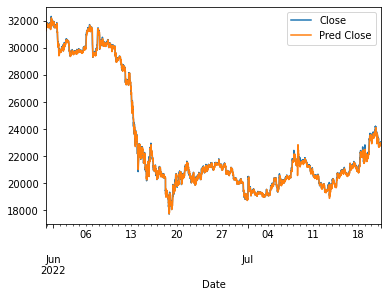

In [31]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period =  +1)
df_preds_true.dropna().plot()
df_preds_true.dropna()

In [32]:
import statsmodels.api as sm

delta_date = df_preds_true.index[-1]-df_preds_true.index[-2]
res=(df_preds_true["Close"] - df_preds_true["Pred Close"]).dropna()
lb, p = sm.stats.diagnostic.acorr_ljungbox(res, lags=20, boxpierce=False)
p

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

Initial time 2022-05-30 21:30:00
Final time 2022-07-21 11:00:00
Fee: 0.025
----------------------
Buy      4948 ( 2896 ok 2052 ko )
Avg PCT gain: 1.0037570458551592
Avg PCT loss: 0.9982116854604466
Wins  PCT   0.5852869846402587
Avg PCT Gain.    1.0037570458551592
No-op    0
Wallet   149618.16775000017
Drawback -683.3982500000033
Kelly Fraction    0.17286509454837395
Total earned 149618.16775000017


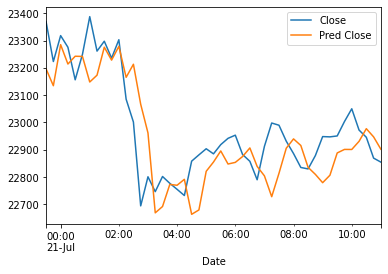

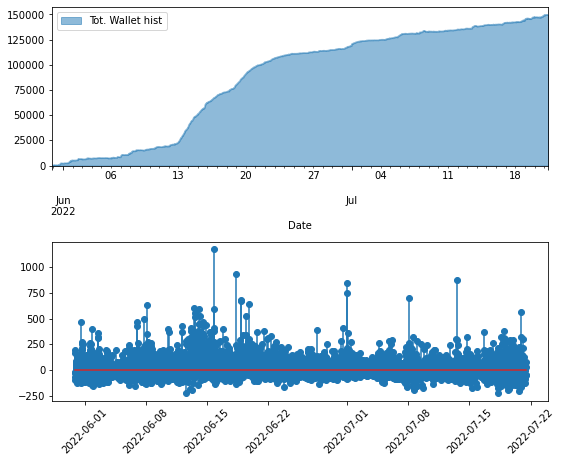

In [45]:
step_back_val = 2
if new_time_steps > step_back_val :
    df_preds_true.iloc[-48:].dropna().plot()

    wallet_hist_df, wallet, kelly_frac = s2b.backtest_df(df_preds_true.iloc[-new_time_steps*10:].dropna(), step_back=+ 2,
                                                    long_short = "longshort", compare_true_data=True,
                                                    fee=0.025, cutoff_long =10. ,cutoff_short = 10.0)
    s2b.show_backtest_results(wallet,wallet_hist_df)

Initial time 2022-07-09 09:15:00
Final time 2022-07-21 11:00:00
Fee: 0.025
----------------------
Buy      225 ( 218 ok 7 ko )
Avg PCT gain: 1.0046489649807175
Avg PCT loss: 0.9983346061646561
Wins  PCT   0.9688888888888889
Avg PCT Gain.    1.0046489649807175
No-op    934
Wallet   20815.64949999996
Drawback -85.93600000000015
Kelly Fraction    0.9379733154487151
Total earned 20815.64949999996


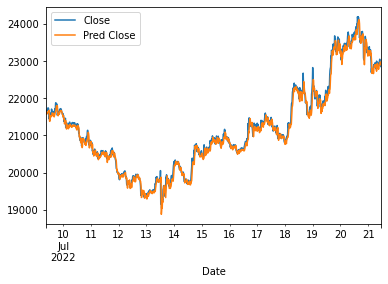

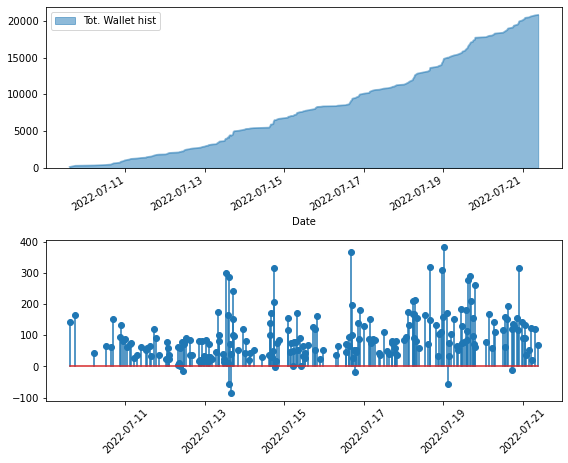

In [36]:
step_back_val = 2
if new_time_steps > step_back_val:
    df_preds_true.iloc[-new_time_steps:].dropna().plot()

    wallet_hist_df, wallet, kelly_frac = s2b.backtest_on_pred_df(df_preds_true.iloc[-new_time_steps:].dropna(), step_back=- 2,
                                                                long_short="long", compare_true_data=True,
                                                                fee=0.025, cutoff_long=100., cutoff_short=100.0)
    s2b.show_backtest_results(wallet, wallet_hist_df)

In [13]:
wallet_hist_df


,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-21 09:15:00,67.8795,67.8795


In [14]:
df_preds_true

,Close,Pred Close
Date,,
2017-08-17 06:30:00,4345.45,NaN
2017-08-17 06:45:00,4324.35,NaN
2017-08-17 07:00:00,4316.62,NaN
2017-08-17 07:15:00,4291.38,NaN
2017-08-17 07:30:00,4300.00,NaN
...,...,...
2022-07-21 10:00:00,23050.27,22901.202774
2022-07-21 10:15:00,22972.31,22930.930283
2022-07-21 10:30:00,22945.87,22977.338191


In [15]:
df_preds_true["Return Expected"] = tu.log_return(
    df_preds_true["Close"], periods=-1)
df_preds_true["Return Predicted"] = tu.log_return(
    df_preds_true["Pred Close"], periods=-1)


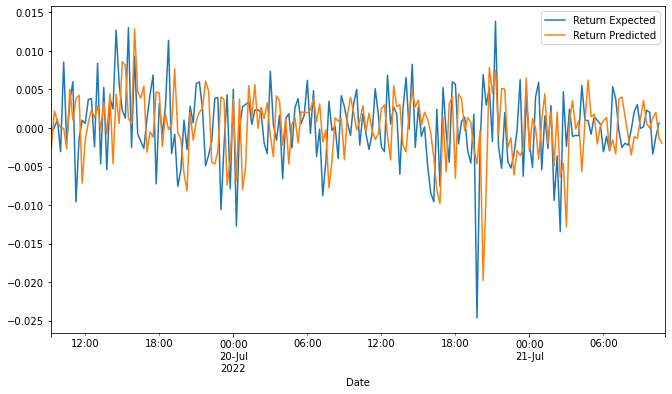

In [16]:
f, axs = plt.subplots(figsize=(11, 6))
df_preds_true.iloc[-200:].plot(y="Return Expected", ax=axs)
df_preds_true.iloc[-200:].plot(y="Return Predicted", ax=axs)


In [17]:
print(step_back)
df_preds_true = tu.merge_true_preds(can_btc.candles, preds, period=+1)
df_preds_true_shifted = df_preds_true.copy()
df_preds_true_shifted.iloc[:, 1] = df_preds_true.iloc[:, 1].shift(step_back, delta_date)
df_preds_true_shifted[-20:].dropna().plot()
df_preds_true[-20:].dropna().plot()

NameError: name 'step_back' is not defined

In [ ]:
def tryexceptwait(func):
  def inner(*args,**kwargs):
        try:
          return func(*args, **kwargs)
        except:
          time.sleep(61)
          return func(*args,**kwargs)
  return inner

@tryexceptwait
def getminutedata(binance_client, ticker,interval, look_back):

  frame = pd.DataFrame(binance_client.get_historical_klines(ticker,interval, look_back + "min ago UTC"))
  frame = frame.iloc[:,:6]
  frame.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
  frame = frame.set_index("Time")
  frame.index = pd.to_datetime(frame.index,unit = "ms")
  frame = frame.astype(float)
  return frame

def print_time_status_and_sleep(prev_close_date,delta_date,dt_unit,log,sleep=True):

  elapsed_minutes = (pd.Timestamp(datetime.now()) -
                     prev_close_date).seconds/dt_unit
  time_condition = 1. < delta_date.seconds/dt_unit - elapsed_minutes < + 1.
  min_till_close = (delta_date.seconds/dt_unit - elapsed_minutes)
  log.write(f'Current Time: {pd.Timestamp(datetime.now())}\n')
  log.write(f'Minutes till Next Close: {min_till_close}\n')
  if sleep:
    log.write(f"Sleep for {min_till_close} mins.\n")
    time.sleep(min_till_close*dt_unit - 10)
    log.write(f"finished to sleep at {pd.Timestamp(datetime.now())}\n")

non_decimal = re.compile(r'[^\d.]+')
n_klines = crypto.kline_size
n_klines = non_decimal.sub('',n_klines)

#example: 
# a='123.f.'
# non_decimal.sub('', a )
# a='123'

# print(
#     f'Current limit is {buyprice*(1+avg_change)} or close position in {str(time_until_close)}')
# print(
#     f'Current stop is {buyprice*(1-avg_change)} or close position in {str(time_until_close)}')


In [ ]:
df_preds_true.iloc[-30:]

,Close,Pred Close,Return Expected,Return Predicted
Date,,,,
2022-07-13 05:45:00,19520.00,19471.580439,-0.001075,0.001252
2022-07-13 06:00:00,19499.03,19495.966031,-0.000960,0.000393
2022-07-13 06:15:00,19480.32,19503.628671,0.002457,-0.001003
2022-07-13 06:30:00,19528.24,19484.067826,0.000971,-0.001426
2022-07-13 06:45:00,19547.22,19456.294438,-0.001219,0.001575
2022-07-13 07:00:00,19523.40,19486.971184,-0.000503,0.000819
2022-07-13 07:15:00,19513.59,19502.931472,0.009093,-0.000637
2022-07-13 07:30:00,19691.84,19490.519370,0.000681,0.000197
2022-07-13 07:45:00,19705.25,19494.355600,-0.000641,0.004347


In [ ]:

investment = 1000.
conservative_kelly = kelly_frac*.5
portfolio = investment
open_position = False
avg_change = 0.004
fee = 0.025
step_back = -2
cutoff_long = 100.
verbose = True

total_wallet_history = []
single_wallet_history = []
single_wallet_hist_deb = []
time_history = []
fill_order_history = []
time_fill_order_history = []
close_order_history = []

wallet = 0.
buys_cnt = 0
buys_cnt_win = 0
buys_cnt_losses = 0
drawback = 0
old_profit_negative = False
old_profits = 0
mean_pct_gain = 0
mean_pct_loss = 0

last_dates = getminutedata(
    crypto.binance_client, tickers[0], crypto.kline_size, '30').index
delta_date = last_dates[-1]-last_dates[-2]
prev_close_date = last_dates[-1]
buffer_delta = 0.01*delta_date

current_time = pd.datetime.now().strftime("%y%m%d_%H_%M_%S")
log = open(f'{dir_to_save}/trade_session_{current_time}.log', 'w', 1)

while True:
 
    print_time_status_and_sleep(prev_close_date, delta_date, crypto.dt,log,sleep = True)
    ldata_df_new = crypto.load_cryptos(tickers,save = False)
    can_btc = fb.Candles(ldata_df_new,"Bitcoin")
    can_btc.buildfeatures()
    ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 2000, step_back = 48, candle_step_str = crypto.kline_size,
                    lownorm = 0.2, upnorm= 0.8)

    ts_btc.candles2ts(verbose = False)
    ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
    ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)
    initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))
    loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler, split_fraction = 1)
    loaded_model.sats2model()
    loaded_model.load_model(model_name)
    loaded_model.sats2pred(predict_on_test=False)
    loaded_model.load_scaler(model_name + '/scaler.sav')
    preds = c2t.denorm(loaded_model.scaler, can_btc.candles, loaded_model.preds)
    df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = +1)
    df_preds_true_shifted = df_preds_true.copy()
    df_preds_true_shifted.iloc[:,1] = df_preds_true.iloc[:,1].shift(step_back,delta_date)
    prev_true_close = df_preds_true_shifted.dropna().iloc[-2,0]
    pred_close = df_preds_true_shifted.dropna().iloc[-1,1]
    prev_close_date = ldata_df_new["Date"].iloc[-1]    
    print_time_status_and_sleep(prev_close_date, delta_date, crypto.dt, log, sleep=False)

    current_time = pd.Timestamp(datetime.now())
    if df_preds_true_shifted.index[-1] > current_time:
        sec_till_close = (df_preds_true_shifted.index[-1] - current_time).seconds
        time.sleep(sec_till_close)
        print(f"sleep for {sec_till_close} s")

    if open_position == False :

        if prev_true_close*(1+fee/cutoff_long) < pred_close:

            log.write("Will open an order!\n")
            dff = getminutedata(crypto.binance_client, tickers[0],'1m','120')
            if not np.isnan(conservative_kelly):
                buy_quantity = round(portfolio*conservative_kelly / float(dff['Close'].iloc[-1]))
            buy_quantity = 0.1

            balances = crypto_test.binance_client.get_account()['balances']
            balances_dict = {balances[i]["asset"]: float(balances[i]["free"]) for i in 
                            range(len(balances)) if balances[i]["asset"] in tickers[0]}
            balance_before_open = balances_dict["USDT"]

            order = crypto_test.binance_client.create_order(symbol=tickers[0],
                                                    side='BUY',
                                                    type='MARKET',
                                                    quantity= buy_quantity)
                                                        
            order_time = pd.Timestamp(datetime.now())
            est_close_time = df_preds_true_shifted.index[-1] + delta_date
            open_position = True
            filled_open_price = float(order['fills'][0]['price'])
            filled_open_deb = buy_quantity* filled_open_price

            log.write('-----------------------------------\n')
            log.write(f'Order filled at {str(order_time)}\n')
            log.write(f'Order will be closed around {str(est_close_time)}\n')
            log.write(f'Filled open price: {filled_open_price}\n')
            log.write(f'Previous close price: {prev_true_close}\n')
            log.write(f'Predicted close price: {pred_close}\n')

            while open_position :

                time.sleep(60)
                dff = getminutedata(crypto.binance_client, tickers[0],'1m','2')
                current_price = dff["Close"].iloc[-1]
                current_time = pd.Timestamp(datetime.now())
                time_until_close = (est_close_time - current_time - buffer_delta )

                if verbose:
                    log.write('--------------------------------\n')
                    log.write(f'Current price: {current_price}\n')
                    log.write(f'Current time: {current_time}\n')
                    log.write(
                        f'Time until close of position: {time_until_close} mins.\n')
                    log.write(
                        f'Position will be closed at {time_until_close + current_time}\n')

                if (time_until_close.seconds/crypto.dt) < 0:
                    log.write(
                        'WARNING: Something must have gone wrong time should not be < 0\n')
                    log.write('Restart loop\n')
                    break
                
                elif (time_until_close.seconds/crypto.dt) < 1 :

                    order = crypto_test.binance_client.create_order(symbol=tickers[0],
                                                                side='SELL',
                                                                type='MARKET',
                                                                quantity= buy_quantity)  
                    open_position = False
                    filled_close_price = float(order['fills'][0]['price'])
                    filled_close_deb = buy_quantity*filled_close_price
                    order_close_time = pd.Timestamp(datetime.now())

                    balances = crypto_test.binance_client.get_account()['balances']
                    balances_dict = {balances[i]["asset"]: float(balances[i]["free"]) for i in 
                            range(len(balances)) if balances[i]["asset"] in tickers[0]}
                    balance_after_close = balances_dict["USDT"]
                    profit_deb = filled_close_deb - filled_open_deb
                    profit = balance_after_close - balance_before_open
                    wallet += profit
                    total_wallet_history.append(wallet)
                    single_wallet_history.append(profit)
                    single_wallet_hist_deb.append(profit_deb)
                    time_history.append(order_close_time)
                    buys_cnt += 1

                    log.write(f'Position closed at {str(order_close_time)}\n')
                    log.write(f'Filled open price: {filled_open_price}\n')
                    log.write(f'Filled close price: {filled_close_price}\n')
                    log.write(f'Position closed at {str(order_close_time)}\n')
                    log.write(f'Profit: {profit}\n')
                    prev_close_date = getminutedata(crypto.binance_client, tickers[0], crypto.kline_size, n_klines).index[-1]
                
                    if profit > 0:
                        buys_cnt_win += 1
                        old_profit_negative = False
                        mean_pct_gain += filled_close_price / filled_open_price
                    else:
                        buys_cnt_losses += 1
                        mean_pct_loss += filled_close_price / filled_open_price
                        if old_profit_negative:
                            old_profits += profit
                        else:
                            old_profits = profit
                        if old_profits < drawback:
                            drawback = old_profits
                        old_profit_negative = True                    
        else:
            old_profit_negative = False
            old_profits = 0
            dff = getminutedata(
                crypto.binance_client, tickers[0], crypto.kline_size, n_klines)
            prev_close_date = dff.index[-1]
            log.write(f'Order not filled\n')
            log.write(f'Previous true close with fee: {prev_true_close*(1+fee/cutoff_long)}\n')
            log.write(f'Predicted close: {pred_close}\n')
            
        wallet_hist_df = pd.DataFrame(
            np.array([total_wallet_history, single_wallet_history, single_wallet_hist_deb ]).T,
            index=pd.Series(time_history, name="Date"),
            columns=["Tot. Wallet hist", "Single Wallet hist","Single Wallet hust deb" ],
        )
        display(wallet_hist_df)
        wallet_hist_df.to_csv(dir_to_save + "/live_wallet_history.csv")


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-13 13:44:28.822469,22.008807,22.008807,22.026


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-13 13:44:28.822469,22.008807,22.008807,22.026


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


KeyboardInterrupt: 

In [ ]:
df_preds_true = tu.merge_true_preds(can_btc.candles, preds, period=+1)
df_preds_true_shifted = df_preds_true.copy()
df_preds_true_shifted.iloc[:, 1] = df_preds_true.iloc[:, 1].shift(
    -3, delta_date)
df_preds_true_shifted
df_preds_true

,Close,Pred Close
Date,,
2017-08-17 06:30:00,4345.45,NaN
2017-08-17 06:45:00,4324.35,NaN
2017-08-17 07:00:00,4316.62,NaN
2017-08-17 07:15:00,4291.38,NaN
2017-08-17 07:30:00,4300.00,NaN
...,...,...
2022-07-11 21:45:00,20239.38,20342.352273
2022-07-11 22:00:00,20113.41,20310.592086
2022-07-11 22:15:00,20109.07,20201.059864


In [ ]:
def kelly_exp_simple(pct_gain, pct_loss, n_wins):

    if pct_loss != 0.0 and pct_gain != 0.0:
        win_loss_ratio = pct_gain / pct_loss
        kelly_frac = n_wins - (1 - n_wins) / win_loss_ratio
    else:
        kelly_frac = np.nan
    return kelly_frac


def backtest_df_debug(df_preds_true, step_back=10, long_short="long", fee=0.025, cutoff_long=10.0, cutoff_short=10.0):

    if long_short != "long" and long_short != "short" and long_short != "longshort":
        raise ValueError("long_short can only be long, short or longshort")

    if cutoff_long < 1.0 or cutoff_short < 1.0:
        raise ValueError(
            "cutoff_long and cutoff_short should be greater/equal to 1.0")

    wallet = 0
    total_wallet_history = []
    single_wallet_history = []
    datetime_iter = []

    fee_factor_long = 1 + fee / cutoff_long
    fee_factor_short = 1 + fee / cutoff_short

    buys_cnt = 0
    buys_cnt_win = 0
    buys_cnt_losses = 0
    no_op = 0
    drawback = 0
    old_profit_negative = False
    old_profits = 0
    mean_pct_gain = 0
    mean_pct_loss = 0

    delta = df_preds_true.index[1] - df_preds_true.index[0]
    df_preds_true.iloc[:, 0] = df_preds_true.iloc[:, 0].shift(step_back, delta)

    previous_true_close = df_preds_true.iloc[step_back, 0]
    previous_pred_close = df_preds_true.iloc[step_back, -1]
    print("Initial time", df_preds_true.index[0])
    print("Final time", df_preds_true.index[-1])
    it = 0

    for index, row in df_preds_true.iloc[step_back + 1:].iterrows():
        true_close = row[0]
        pred_close = row[-1]
        it += 1

        if long_short == "long":
            if previous_pred_close * fee_factor_long < pred_close:  # long
                profit = true_close - previous_true_close
                if profit > 0:
                    profit = profit - (profit * fee)
                    buys_cnt_win += 1
                    old_profit_negative = False
                    mean_pct_gain += true_close / previous_true_close

                else:
                    profit = profit + (profit * fee)
                    buys_cnt_losses += 1
                    mean_pct_loss += true_close / previous_true_close
                    if old_profit_negative:
                        old_profits += profit
                    else:
                        old_profits = profit
                    if old_profits < drawback:
                        drawback = old_profits
                    old_profit_negative = True
                wallet += profit
                total_wallet_history.append(wallet)
                single_wallet_history.append(profit)
                datetime_iter.append(it)
                buys_cnt += 1
            else:
                old_profit_negative = False
                old_profits = 0
                no_op += 1

        elif long_short == "short":
            if previous_true_close * fee_factor_short > pred_close:  # short
                profit = -1 * (true_close - previous_true_close)
                if profit > 0:
                    # win
                    profit = profit - (profit * fee)
                    buys_cnt_win += 1
                    old_profit_negative = False
                    # if short we gain (i.e. mean_pct_gain >1 ) when prev close > true close
                    mean_pct_gain += previous_true_close / true_close
                else:
                    # loss
                    profit = profit + (profit * fee)
                    buys_cnt_losses += 1
                    # if we short we lose (i.e. mean_pct_loss < 1) when prev close < true close
                    mean_pct_loss += previous_true_close / true_close
                    if old_profit_negative:
                        old_profits += profit
                    else:
                        old_profits = profit
                    if old_profits < drawback:
                        drawback = old_profits
                    old_profit_negative = True
                wallet += profit
                total_wallet_history.append(wallet)
                single_wallet_history.append(profit)
                datetime_iter.append(it)
                buys_cnt += 1
            else:
                old_profit_negative = False
                old_profits = 0
                no_op += 1

        elif long_short == "longshort":
            if previous_true_close * fee_factor_short > pred_close:  # short
                profit = true_close - previous_true_close
                if profit < 0:
                    # win
                    profit = -1 * (profit - (profit * fee))
                    buys_cnt_win += 1
                    old_profit_negative = False
                    # if short we gain (i.e. mean_pct_gain >1 ) when prev close > true close
                    mean_pct_gain += previous_true_close / true_close
                else:
                    # loss
                    profit = -1 * (profit + (profit * fee))
                    buys_cnt_losses += 1
                    # if we short we lose (i.e. mean_pct_loss < 1) when prev close < true close
                    mean_pct_loss += previous_true_close / true_close
                    if old_profit_negative:
                        old_profits += profit
                    else:
                        old_profits = profit
                    if old_profits < drawback:
                        drawback = old_profits
                    old_profit_negative = True
                wallet += profit
                total_wallet_history.append(wallet)
                single_wallet_history.append(profit)
                datetime_iter.append(it)
                buys_cnt += 1
            elif previous_true_close * fee_factor_long < pred_close:  # long
                profit = true_close - previous_true_close
                if profit > 0:
                    profit = profit - (profit * fee)
                    buys_cnt_win += 1
                    old_profit_negative = False
                    mean_pct_gain += true_close / previous_true_close
                else:
                    profit = profit + (profit * fee)
                    buys_cnt_losses += 1
                    mean_pct_loss += true_close / previous_true_close
                    if old_profit_negative:
                        old_profits += profit
                    else:
                        old_profits = profit
                    if old_profits < drawback:
                        drawback = old_profits
                    old_profit_negative = True
                wallet += profit
                total_wallet_history.append(wallet)
                single_wallet_history.append(profit)
                datetime_iter.append(it)
                buys_cnt += 1
            else:
                old_profit_negative = False
                old_profits = 0
                no_op += 1

        previous_true_close = true_close
        previous_pred_close = pred_close

    if buys_cnt_win != 0.0:
        mean_pct_gain /= buys_cnt_win
        wins_pct = buys_cnt_win / buys_cnt
    else:
        wins_pct = 0.0
    if buys_cnt_losses != 0.0:
        mean_pct_loss /= buys_cnt_losses

    print("Fee:", fee)
    print("----------------------")
    print("Buy     ", buys_cnt, "(", buys_cnt_win, "ok", buys_cnt_losses, "ko )")
    print("Avg PCT gain:", mean_pct_gain)
    print("Avg PCT loss:", mean_pct_loss)
    print("Wins  PCT  ", wins_pct)
    print("Avg PCT Gain.   ", mean_pct_gain)
    print("No-op   ", no_op)
    print("Wallet  ", wallet)
    print("Drawback", drawback)

    kelly_frac = kelly_exp_simple(mean_pct_gain, mean_pct_loss, wins_pct)
    print("Kelly Fraction   ", kelly_frac)

    wallet_hist_df = pd.DataFrame(
        np.array([total_wallet_history, single_wallet_history]).T,
        index=df_preds_true.index[datetime_iter],
        columns=["Tot. Wallet hist", "Single Wallet hist"],
    )
    return wallet_hist_df, wallet, kelly_frac

### Try with Long Short Strategy here. First write functions to make code a bit shorter

In [ ]:
def get_balance(crypto,ticker):

    balance = crypto.binance_client.get_account()['balances']
    balance_dict = {balance[i]["asset"]: float(balance[i]["free"]) for i in
                 range(len(balances)) if balance[i]["asset"] in ticker}
    balance_cash = balances_dict["USDT"]
    return balance_cash

In [ ]:
def create_order_util(crypto, order_side, enter_or_exit, ticker, investment, kelly_frac, use_testnet = True):

    if order_side != "BUY" and order_side != "SELL":
        raise ValueError("order_side can only be BUY or SELL")
    
    if enter_or_exit != "enter" and enter_or_exit != "exit":
        raise ValueError("enter_or_exit can only be enter or exit")

    dff = getminutedata(crypto.binance_client,ticker,"1m",120)
    buy_quantity = round(investment*kelly_frac / float(dff['Close'].iloc[-1]))
    buy_quantity = 0.001

    balance_before_order = get_balance(crypto, ticker)

    if use_testnet == False and order_side == "SELL" and enter_or_exit == "enter":
        #transaction = client.transfer_spot_to_margin(asset='BTC', amount='1.1')
        order = crypto.binance_client.create_margin_order(symbol=ticker, type='ORDER_TYPE_MARKET', side='SIDE_SELL',
                                quantity=buy_quantity, sideEffectType='MARGIN_BUY', isIsolated=False)

    elif use_testnet == False and order_side == "BUY" and enter_or_exit == "exit":
        order = crypto.binance_client.create_margin_order(symbol=ticker, type='ORDER_TYPE_MARKET', side='SIDE_SELL',
                                        quantity=buy_quantity, sideEffectType='AUTO_REPAY', isIsolated=False)
        #transaction = client.transfer_margin_to_spot(asset='BTC', amount='1.1')
        
    else:
        order = crypto.binance_client.create_order(symbol=ticker,
                                                side=order_side,
                                                type='MARKET',
                                                quantity=buy_quantity)
    
    balance_after_order = get_balance(crypto, ticker)

    if order_side == "BUY" and enter_or_exit == "enter":
        open_position = True
        balance_cash = balance_before_order
    elif order_side == "SELL" and enter_or_exit == "exit":
        open_position = False
        balance_cash = balance_after_order
    elif order_side == "SELL" and enter_or_exit == "enter":
        open_position = True
        balance_cash = balance_before_order
    elif order_side == "BUY" and enter_or_exit == "exit":
        open_position = False
        balance_cash = balance_after_order

    order_time = pd.Timestamp(datetime.now())
    filled_price = float(order['fills'][0]['price'])

    return open_position, order, order_time, filled_price, balance_cash

# est_close_time = df_preds_true_shifted.index[-1]
# ticker = tickers[0]
# order_side = "SELL"
# client = crypto
#open_position, order, order_time, filled_open_price, balance_before_open = create_order_util(crypto, order_side, ticker, investment, kelly_frac)

def check_position_util(crypto,est_close_time,buffer_delta,verbose = False):

    time.sleep(60)
    dff = getminutedata(crypto.binance_client,ticker, '1m', '2')                
    current_price = dff["Close"].iloc[-1]
    current_time = pd.Timestamp(datetime.now())
    time_until_close = (est_close_time - current_time - buffer_delta)

    if verbose:
        print('--------------------------------')
        print(f'Current price: {current_price}')
        print(f'Current time: {current_time}')
        print(f'Time until close of position: {time_until_close} mins.')
        print(f'Position will be closed at {time_until_close + current_time}')

    return current_price, current_time, time_until_close

#current_price, current_time, time_until_close = check_open_position(crypto, est_close_time, buffer_delta, verbose = True)


def pnl_after_close(balance_before, balance_after, filled_open_price):

    filled_close_price = float(order['fills'][0]['price'])
    order_close_time = pd.Timestamp(datetime.now())
    profit = balance_before - balance_after
    wallet += profit
    buys_cnt += 1

    print(f'Position closed at {str(order_close_time)}')
    print(f'Filled open price: {filled_open_price}')
    print(f'Filled close price: {filled_close_price}')
    print(f'Position closed at {str(order_close_time)}')
    print(f'Profit: {profit}')

    if profit > 0:
        buys_cnt_win += 1
        old_profit_negative = False
        mean_pct_gain += filled_close_price / filled_open_price
    else:
        buys_cnt_losses += 1
        mean_pct_loss += filled_close_price / filled_open_price
        if old_profit_negative:
            old_profits += profit
        else:
            old_profits = profit
        if old_profits < drawback:
            drawback = old_profits
        old_profit_negative = True

    return wallet, profit, order_close_time

#wallet, profit, order_close_time, open_position = close_position_util(crypto, crypto_test, order_side, quantity_to_close)
#                    
#total_wallet_history.append(wallet)
#single_wallet_history.append(profit)
#time_history.append(order_close_time)
